In [1]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get current working directory and project root directory
cwd = os.getcwd()
wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not wd.endswith('stochastic-travel-demand-modelling'):
    wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if wd not in sys.path:
    sys.path.append(wd)

from models.singly_constrained.spatial_interaction_model import SpatialInteraction

# Fix seed
np.random.seed(885)

# Import data

In [6]:
# Select dataset
dataset = 'commuter_ward' # 'retail', 'commuter_ward', 'commuter_borough'

# Select cost matrix type
cost_matrix_file = ''
if cost_matrix_file == 'sn':
    cost_matrix_file = '_'+cost_matrix_file

# Select model
constrained = 'singly'

In [7]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(wd,f'data/input/{dataset}/cost_matrix{cost_matrix_file}.txt'))
origin_supply = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

# Normalise origin supply, cost matrix and destination sizes
o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

# Get origin and destination locations
origin_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_locations.txt'))
destination_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/destination_locations.txt'))

# Read Laplace optimisation parameters
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis_gamma_10000_parameters.json') as json_file:
    laplace_low_noise_opt_params = json.load(json_file)
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis_gamma_100_parameters.json') as json_file:
    laplace_high_noise_opt_params = json.load(json_file)
    
# Get dimensions
N,M = cost_matrix.shape

# Construct parameter vector for low noise regime
alpha1 = laplace_low_noise_opt_params['fitted_alpha']
beta1 = laplace_low_noise_opt_params['fitted_scaled_beta']
theta_low_noise = np.array([alpha1,beta1])

# Construct parameter vector for high noise regime
alpha2 = laplace_high_noise_opt_params['fitted_alpha']
beta2 = laplace_high_noise_opt_params['fitted_scaled_beta']
theta_high_noise = np.array([alpha2,beta2])

# Generate initialisations for MCMC sampling

## Low noise

In [8]:
# # # Manually set theta_low_noise
# theta_low_noise[0] = 0.1
# theta_low_noise[1] = 1.7

In [9]:
# Select number of samples to generate
n = 100
# Select mcmc start
mcmc_start = 1

# Generate
theta_low_init = np.random.lognormal(mean=np.log(theta_low_noise),sigma=np.ones(2)*[0.001,0.1],size=(n,2))

# Generate samples from Log Normal distribution cenet
x_low_init = np.log(np.random.lognormal(mean=xd,sigma=np.ones(M)*0.01,size=(n,M)))
sums = [np.sum(x) for x in x_low_init]

# Generate vector of ones for the sign samples
sign_low_init = np.ones((n))

## Theta update step size tuning

In [10]:
# Theta update step size tuning
Ap = np.array([[ 0.00749674,  0.00182529], [ 0.00182529,  0.00709968]])
step = 0.008699999999999998
idx = 0
first_proposal = theta_low_init[idx] + step*np.dot(Ap, np.random.normal(0, 1, 2))

print('Theta opt')
print(theta_low_noise)

print('Theta init')
print(theta_low_init[idx])

print('First theta transition') 
print(first_proposal)

Theta opt
[1.14 0.02]
Theta init
[1.14008136 0.01992068]
First theta transition
[1.14017639 0.01993854]


## Printing initialisations

In [435]:
print('Theta')
print(theta_low_noise)
print('Theta init')
print(theta_low_init[:mcmc_start+1])

Theta
[0.1 1.7]
Theta init
[[0.09984291 1.72791445]
 [0.09991047 1.85165745]]


In [436]:
# actual_theta_initial = np.loadtxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples_initial.txt"))
# print(actual_theta_initial[:mcmc_start+1])

In [437]:
print('Log size init')
print(x_low_init[:mcmc_start+1])

print('True log size')
print(xd)

Log size init
[[-0.65796659 -0.76354931]
 [-0.63646815 -0.73546448]]
True log size
[-0.64662716 -0.74193734]


## Visualise init samples of log destination sizes

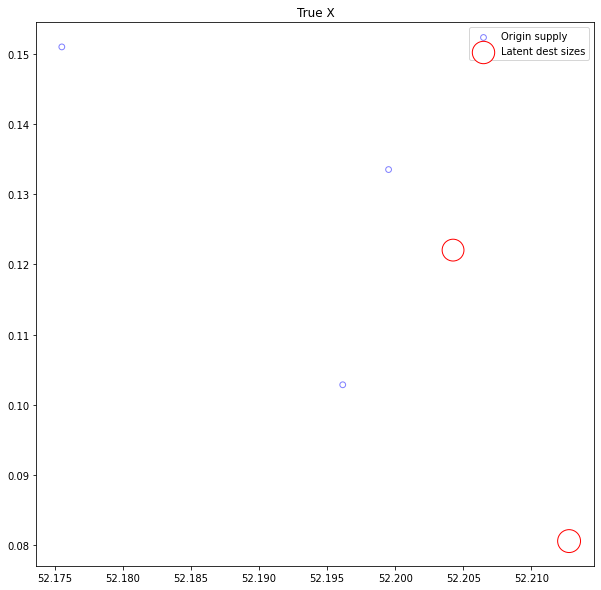

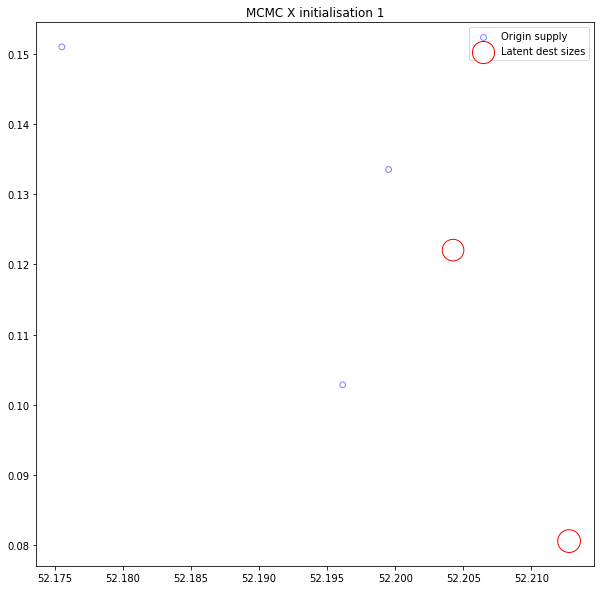

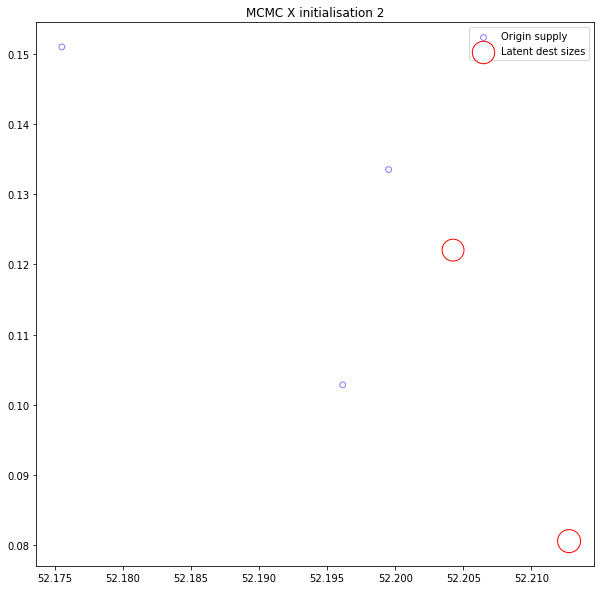

In [438]:
xx1 = x_low_init[:mcmc_start+1][0]
xx2 = x_low_init[:mcmc_start+1][1]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation 1")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx1),label='Latent dest sizes')
plt.legend()

plt.figure(2,figsize=(10,10))
plt.title("MCMC X initialisation 2")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx2),label='Latent dest sizes')
plt.legend()

# Export initilisations

In [439]:
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples_initial.txt"),theta_low_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_logsize_samples_initial.txt"),x_low_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_sign_samples_initial.txt"),sign_low_init)

# np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples_initial.txt"),theta_high_init)
# np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples_initial.txt"),x_high_init)
# np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples_initial.txt"),sign_high_init)